# Supervised learning

#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor

seed = 42
scaler = RobustScaler(quantile_range=(16,84))

Load in the data:

In [2]:
inp_f = fits.open('../data/sw_input.fits')
inp = Table(inp_f[1].data).to_pandas()
inp_f.close()

out_f = fits.open('../data/sw_output.fits')
out = Table(out_f[1].data).to_pandas()
out_f.close()

data = pd.merge(inp, out, left_on='id', right_on='id')

## Data preparation

#### X

Choose what are our X-variables.
Columns:

In [3]:
cols_x = ['flux_u', 'flux_u_e', 'flux_g', 'flux_g_e', 'flux_r', 'flux_r_e', 'flux_i', 'flux_i_e', 'flux_z', 'flux_z_e',
       'flux_w1', 'flux_w1_e', 'flux_w2', 'flux_w2_e', 'flux_w3', 'flux_w3_e', 'flux_w4', 'flux_w4_e']

X = data[cols_x].values
xscaler = RobustScaler(quantile_range=(16,84))
xscaler.fit(X)
X = xscaler.transform(X)

Keep only "good" values, i.e. those where the values in *any* filter are less than 10$\sigma$ away from the mean; also throw away anything that is flagged in the Chang catalog.

In [4]:
sigma_thresh = 10
bad_ids = np.any(np.abs(X) > sigma_thresh, axis=1)
bad_ids = bad_ids | (out.flag != 1)
X = X[~bad_ids, :]

#### Y

Things we want to predict. Columns:

In [5]:
cols_y = ['redshift', 'lmass50_all']
Y = data[cols_y].values
Y = Y[~bad_ids, :]

Scaler for the Y values:

In [6]:
yscaler = RobustScaler(quantile_range=(16,84))
yscaler.fit(Y)
Y = yscaler.transform(Y)

#### Train/test

Split up the data randomly:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=seed)

## Train the model

Let's use, for example, Perceptron regressor for this.

In [8]:
network = MLPRegressor(hidden_layer_sizes=(100,100,100,100), random_state=seed, max_iter=500)

In [9]:
network.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100), max_iter=500,
             random_state=42)

In [10]:
y_pred = network.predict(X_test)

Transform the data back

In [11]:
y_og_pred = yscaler.inverse_transform(y_pred)
y_og_test = yscaler.inverse_transform(y_test)

## Plots!

The performance of the network overall on the test set:

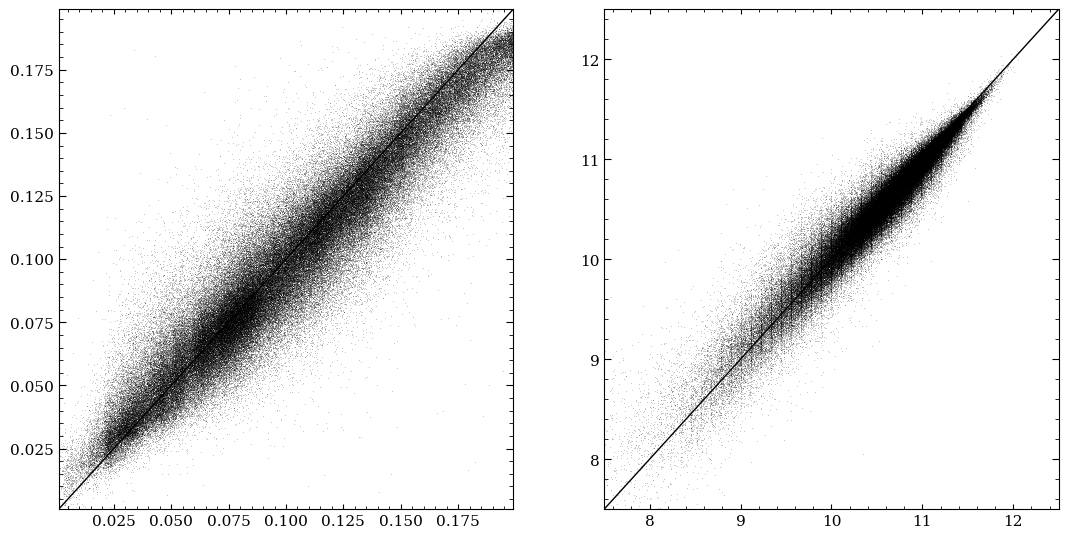

In [12]:
fig,axs = plt.subplots(1,2,figsize=(10,5))

axs[0].scatter(y_og_test[:,0], y_og_pred[:,0], s=1, color='k', alpha=0.3)
axs[1].scatter(y_og_test[:,1], y_og_pred[:,1], s=1, color='k', alpha=0.3)

axs[0].set_xlim(0.001,0.199)
axs[0].set_ylim(0.001,0.199)

axs[1].set_xlim(7.5,12.5)
axs[1].set_ylim(7.5,12.5)

for ax in axs:
    ax.plot([0,1],[0,1], 'k-', lw=1, transform=ax.transAxes)

### SPOGs?

Does the network work well on SPOGs? Let's see

In [55]:
spogs = pd.read_csv('spogs.csv')
spog_ids = spogs['id'].drop_duplicates().values
spogs = data[data.id.isin(spog_ids)]
# spogs = spogs[spogs.flag == 1]
spogs = spogs.iloc[spog_bad_ids]
# spogs = spogs[(spogs.redshift >= 0.15) | (spogs.lmass50_all <= 9)]

Select and transform data:

In [56]:
X_spogs = xscaler.transform(spogs[cols_x].values)
Y_spogs = yscaler.transform(spogs[cols_y].values)
Y_pred_spogs = network.predict(X_spogs)

Plot them on the same figure:

In [57]:
Y_og_spogs = spogs[cols_y].values
Y_og_pred_spogs = yscaler.inverse_transform(Y_pred_spogs)

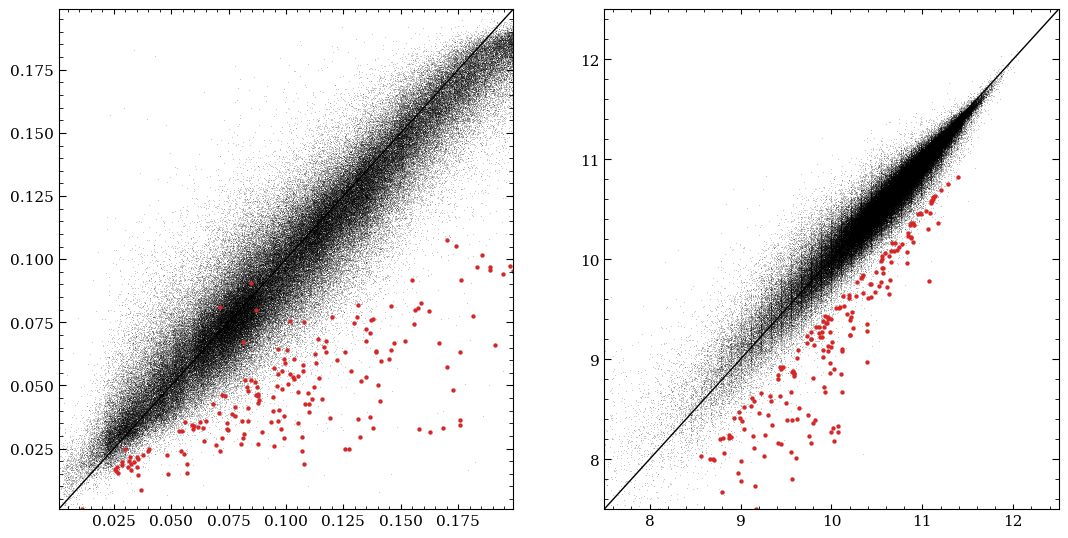

In [58]:
fig,axs = plt.subplots(1,2,figsize=(10,5))

axs[0].scatter(y_og_test[:,0], y_og_pred[:,0], s=1, color='k', alpha=0.3)
axs[1].scatter(y_og_test[:,1], y_og_pred[:,1], s=1, color='k', alpha=0.3)


axs[0].scatter(Y_og_spogs[:,0], Y_og_pred_spogs[:,0], s=40, color='C3', alpha=1)
axs[1].scatter(Y_og_spogs[:,1], Y_og_pred_spogs[:,1], s=40, color='C3', alpha=1)


axs[0].set_xlim(0.001,0.199)
axs[0].set_ylim(0.001,0.199)

axs[1].set_xlim(7.5,12.5)
axs[1].set_ylim(7.5,12.5)

for ax in axs:
    ax.plot([0,1],[0,1], 'k-', lw=1, transform=ax.transAxes)

In [53]:
err = Y_og_spogs-Y_og_pred_spogs

In [54]:
spog_bad_ids = err[:,1] > 0.5

In [60]:
spogs[['id']].to_csv('test_sample.csv', index=False)